# 07. 여러개를 분류합니다. - 다중 분류

## 07-1 여러 개의 이미지를 분류하는 다층 신경망을 만듭니다.

다중 분류 신경망을 만들기 위해서는 소프트맥스(softmax) 함수와 크로스 엔트로피(cross-entropy) 손실 함수라는 새로운 재료를 알아야 합니다. 

### 소프트맥스 함수 적용해 출력 강도를 정규화합니다.


출력이 N개인 다중 분류 신경망에 대한 소프트맥스 함수의 정의는 다음과 같습니다.</br>

$$\cfrac{e^{z_i}}{\sum_{k=1}^{n}e^{z_{k}}}$$

시그모이드 함수를 z에 대해서 정리하면</br>

$$z=-ln(\cfrac{1}{\hat{y}} - 1)$$ 이 됩니다. 이 공식을 통해 나온 값들을 적용하면 정규화된 결과를 얻을 수 있습니다.

### 크로스 엔트로피 손실 함수를 도입합니다.

크로스 엔트로피 함수는 로지스틱 손실 함수를 일반화 했다고 불립니다. 그 이유는 로지스틱 손실 함수가 크로스 엔트로피 손실 함수의 이진 분류 버전이기 때문입니다.</br>

$$L = -\sum_{c=1}^c y_clog(a_c)$$

결과적으로 $y_c$를 곱하기 때문에 분류하고자 하는 대상이 아닌 항목의 y 값은 0 이기 때문에 0이 곱해져서 원하는 항목의 확률을 구할 수 있습니다.

In [1]:
!pip install tensorflow_gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 72kB/s 
     |████████████████████████████████| 501kB 44.8MB/s 
     |████████████████████████████████| 4.3MB 40.0MB/s 


In [9]:
import numpy as np

a = np.zeros((3, 2))
a[2][1] =3
a[1][0] =1
print(a)
a.reshape(1, -1)

[[0. 0.]
 [1. 0.]
 [0. 3.]]


array([[0., 0., 1., 0., 0., 3.]])

In [0]:
class MultiClassNetwork:
  
  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
  
  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2
  
  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0)/m
    
    return w1_grad, b1_grad, w2_grad, b2_grad
  
  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a
  
  def softmax(self, z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
  
  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1, (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, n_classes))
    self.b2 = np.zeros(n_classes)
  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])
    
    for i in range(epochs):
      loss = 0
      print('.', end='')
      
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        
        loss += np.sum(-y_batch*np.log(a))
        
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)
      
  def gen_batch(self, x, y):
      length = len(x)
      bins = length // self.batch_size # 미니 배치 횟수
      if length % self.batch_size:
        bins += 1
      indexes = np.random.permutation(np.arange(len(x)))
      
      x = x[indexes]
      y = y[indexes]
      
      for i in range(bins):
        start = self.batch_size * i
        end = self.batch_size * (i+1)
        yield x[start:end], y[start:end]
  def training(self, x, y):
    m = len(x)
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y-a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    #규제
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    
    return a
  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z, axis=1)
  
  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))
  
  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1))) + np.sum(np.abs(self.w2)) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))
  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    
    val_loss = np.sum(-y_val*np.log(a))
    self.val_losses.append((val_loss + self.reg_loss())/len(y_val))

In [0]:
import tensorflow as tf

In [15]:
tf.__version__

'2.0.0-rc1'

In [17]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [19]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


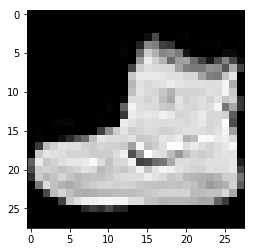

In [20]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [21]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [0]:
class_names = ['티셔츠', '바지', '스웨터', '드레스', '코드', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [23]:
print(class_names[y_train_all[0]])

앵클부츠


In [24]:
import numpy as np
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [26]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [27]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [0]:
x_train = x_train / 255
x_val = x_val / 255

In [0]:
x_train = x_train.reshape(-1, 28*28)
x_val = x_val.reshape(-1, 28*28)


In [30]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [31]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [32]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [33]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

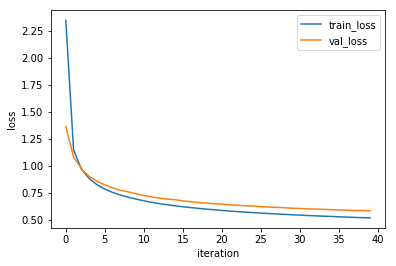

In [35]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [36]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

In [0]:
# 정확도가 81.5% 정도로 너무 낮아서 찍었을 때 정확도 10% 보다는 높지만 실전에서 사용하기에는 어렵습니다.

## 07-2 텐서플로와 케라스를 사용하여 신경망을 만듭니다.

케라스는 딥러닝 패키지를 편리하게 사용하기 위해 만들어진 래퍼패키지 입니다. 따라서 케라스를 사용합니다.

In [38]:
#신경망 모델을 만듭니다.
model = tf.keras.models.Sequential()
#완전 연결층을 추가합니다.
model.add(tf.keras.layers.Dense(1))
# 옵티마이저와 손실 함수를 지정합니다.
model.compile(optimizer='sgd', loss='mse')
# 훈련 데이터를 사용하여 에포크 횟수만큼 훈련한다
model.fit(x_train, y_train, epochs=10)

Train on 48000 samples
Epoch 1/10
48000/48000 [==============================] - 3s 52us/sample - loss: nan
Epoch 2/10
48000/48000 [==============================] - 2s 41us/sample - loss: nan
Epoch 3/10
48000/48000 [==============================] - 2s 42us/sample - loss: nan
Epoch 4/10
48000/48000 [==============================] - 2s 42us/sample - loss: nan
Epoch 5/10
48000/48000 [==============================] - 2s 42us/sample - loss: nan
Epoch 6/10
48000/48000 [==============================] - 2s 42us/sample - loss: nan
Epoch 7/10
48000/48000 [==============================] - 2s 42us/sample - loss: nan
Epoch 8/10
48000/48000 [==============================] - 2s 42us/sample - loss: nan
Epoch 9/10
48000/48000 [==============================] - 2s 43us/sample - loss: nan
Epoch 10/10
48000/48000 [==============================] - 2s 42us/sample - loss: nan


In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train_encoded, epochs=40,
                   validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 4s 89us/sample - loss: 1.3542 - accuracy: 0.6516 - val_loss: 0.9509 - val_accuracy: 0.7322
Epoch 2/40
48000/48000 [==============================] - 4s 79us/sample - loss: 0.8357 - accuracy: 0.7444 - val_loss: 0.7459 - val_accuracy: 0.7628
Epoch 3/40
48000/48000 [==============================] - 4s 79us/sample - loss: 0.7073 - accuracy: 0.7659 - val_loss: 0.6597 - val_accuracy: 0.7803
Epoch 4/40
48000/48000 [==============================] - 4s 80us/sample - loss: 0.6430 - accuracy: 0.7808 - val_loss: 0.6087 - val_accuracy: 0.7960
Epoch 5/40
48000/48000 [==============================] - 4s 79us/sample - loss: 0.6014 - accuracy: 0.7942 - val_loss: 0.5736 - val_accuracy: 0.8033
Epoch 6/40
48000/48000 [==============================] - 4s 79us/sample - loss: 0.5714 - accuracy: 0.8037 - val_loss: 0.5479 - val_accuracy: 0.8085
Epoch 7/40
48000/48000 [==============================] 

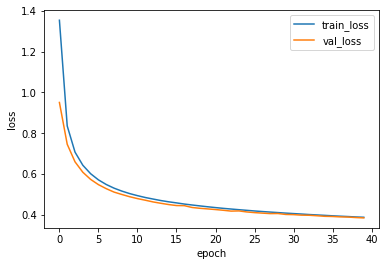

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

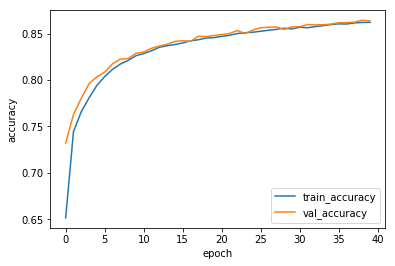

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy') # 오타 loss -> accuracy
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

정확도가 86% 밖에 안나와서 위에서 만들었던 모델에 비해 5% 정도 밖에 향상되지 않았음을 알 수 있다.
이 이유는 케라스의 성능이 나쁜 것이 아니라 다중 분류 신경망이 이미지 데이터에 잘 맞는 모델이 아니기 때문입니다.
다음 장에서는 이미지 분류에 아주 효과적인 신경망인 합성곱 신경망(convolution neural network)에 대해 살펴보겠습니다.